In [1]:
import ROOT
import numpy as np
from ROOT import TGraphErrors
from ROOT import TVectorT
import matplotlib.pyplot as plt
from matplotlib import ticker
from root_np_functions import *
from plotting_functions import *

Welcome to JupyROOT 6.22/06


## Files and Applied Cuts

In [2]:
prefixes = ["dpp","dth","dph"] #Types of Resolutions
string_selections = ["reco_Missing_const_","reco_No_Missing_const_","reco_NoCuts_"]
cut_labels = ["N_\mathrm{Missed} < 1","N_\mathrm{Missed} \geq 1","\mathrm{No}~N_\mathrm{Missed}~\mathrm{Cuts}"]
B_Fields = [1.4,3.0]

selection_int = 0
B_Field = B_Fields[1]

Cut_String = string_selections[selection_int]
cut_label = cut_labels[selection_int]


root_dir="./"
out_dir = "./"
if (B_Field==1.4):
    filename = root_dir+Cut_String+"output_mom_res_1p4T_combinedsigma_eta_5_p_6_.root"
elif (B_Field==3.0):
    filename = root_dir+Cut_String+"output_mom_res_3T_combinedsigma_eta_5_p_6_.root"

file = ROOT.TFile(filename)
print(filename)
fig_name = out_dir+"%1.1fT_"%(B_Field)+Cut_String+"plots.pdf"
#/No_Missing_const_output_mom_res_1p4T_combinedsigma_eta_5_p_6_.root

./reco_Missing_const_output_mom_res_3T_combinedsigma_eta_5_p_6_.root


## Binning

In [3]:
eta_binning = {}
eta_binning["edges"],N_eta= TVT_to_numpy(file,"TVT_eta_bin")
eta_binning["centers"], eta_binning["widths"] = get_binning_from_edges(eta_binning["edges"])

mom_binning = {}
mom_binning["edges"],N_mom = TVT_to_numpy(file,"TVT_mom_bin")
mom_binning["centers"], mom_binning["widths"] = get_binning_from_edges(mom_binning["edges"])

np.save("./np_arrays/eta_binning",eta_binning)
np.save("./np_arrays/mom_binning",mom_binning)

## TH1 $\rightarrow$ Dictionaries

In [4]:
print(file)
eta_dict = {}
for s in prefixes:
    for eta_v_p in range(N_eta):  #there is a distribution as a function of momentum for each eta bin  
        eta_dict["eta_%s_%i"%(s,eta_v_p)],eta_dict["eta_%s_%i_Errors"%(s,eta_v_p)] = TH1_to_numpy_wErrors(file,"h1_%s_v_p_et_bins_%i"%(s,eta_v_p),True,False)

mom_dict = {}
for s in prefixes:
    for p_v_eta in range(N_mom):    
        mom_dict["p_%s_%i"%(s,p_v_eta)],mom_dict["p_%s_%i_Errors"%(s,p_v_eta)] = TH1_to_numpy_wErrors(file,"h1_%s_v_et_p_bins_%i"%(s,p_v_eta),True,False)

np.save("./np_arrays/%s"%(B_Field)+Cut_String+"momentum",mom_dict)
np.save("./np_arrays/%s"%(B_Field)+Cut_String+"rapidity",eta_dict)

Name: ./reco_Missing_const_output_mom_res_3T_combinedsigma_eta_5_p_6_.root Title: 


### mrad conversion

In [5]:
do_conversion = False
if do_conversion:
    rad_mrad = 1000
    for s in prefixes:
        if (s!="dpp"):
            for eta_v_p in range(N_eta):
                eta_dict["eta_%s_%i"%(s,eta_v_p)]=eta_dict["eta_%s_%i"%(s,eta_v_p)]*rad_mrad
                eta_dict["eta_%s_%i_Errors"%(s,eta_v_p)] = eta_dict["eta_%s_%i_Errors"%(s,eta_v_p)]*rad_mrad
            for p_v_eta in range(N_mom):    
                mom_dict["p_%s_%i"%(s,p_v_eta)] = mom_dict["p_%s_%i"%(s,p_v_eta)]*rad_mrad
                mom_dict["p_%s_%i_Errors"%(s,p_v_eta)] = mom_dict["p_%s_%i_Errors"%(s,p_v_eta)]*rad_mrad

## Colors + Min/Max Y-Axis

In [6]:
eta_colors = get_colors(plt.cm.winter, N_eta)
mom_colors = get_colors(plt.cm.autumn,N_mom)

mom_ranges = get_ranges_from_dict(mom_dict,prefixes,"p",N_mom)
eta_ranges = get_ranges_from_dict(eta_dict,prefixes,"eta",N_eta)

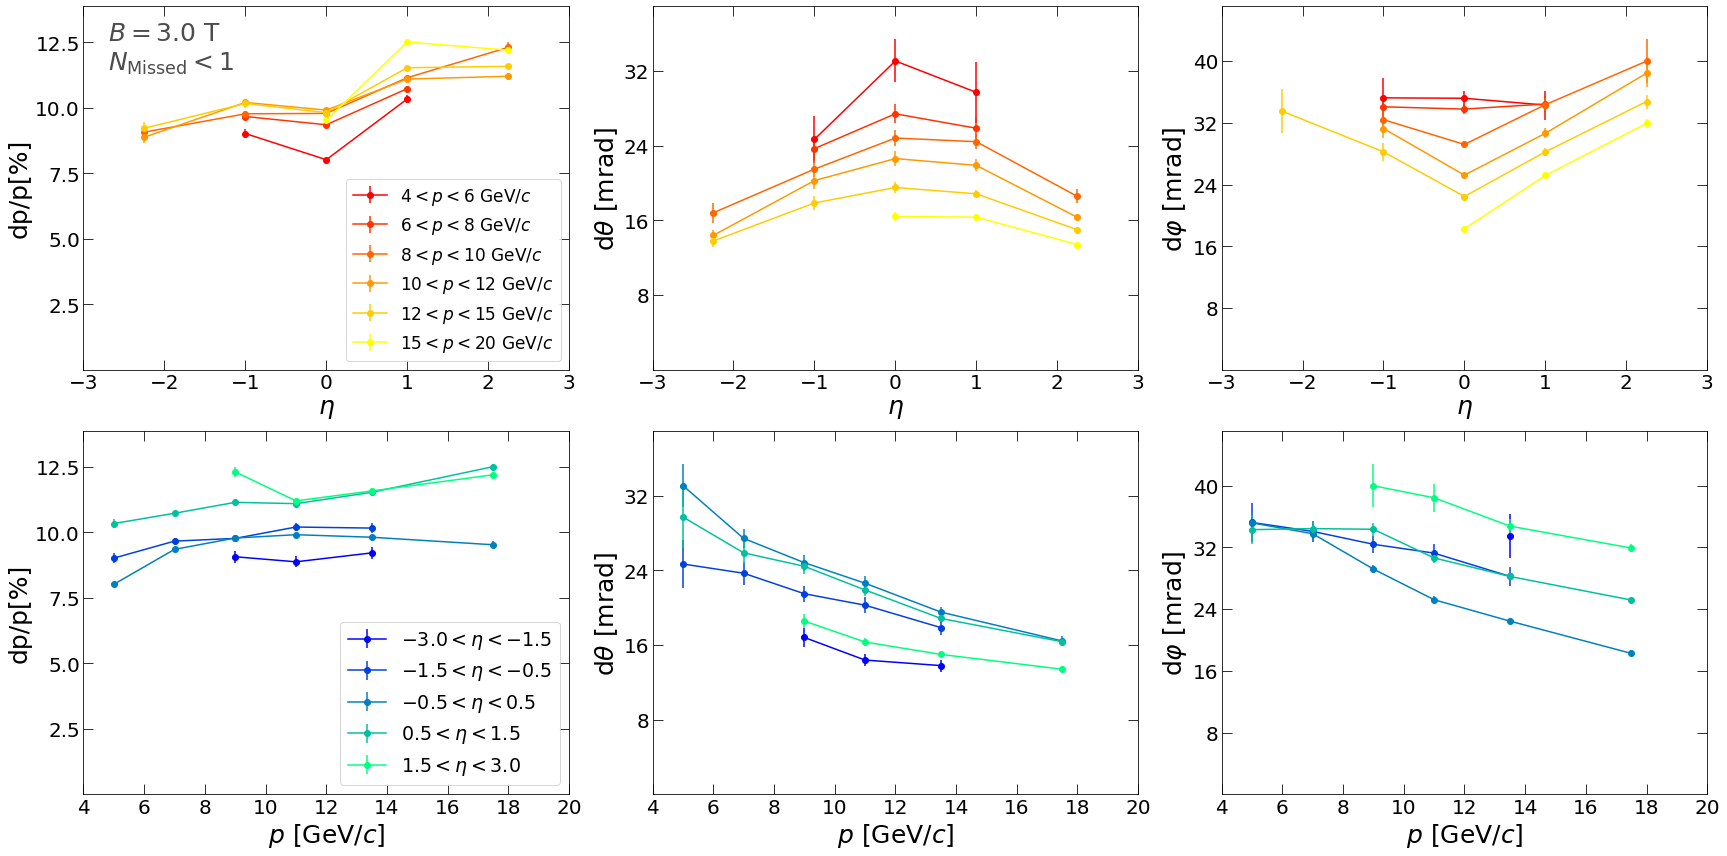

In [7]:
fig = plt.figure(figsize=(24,12))

N_divs = (int(len(mom_dict)/N_mom)) #1/2 factor from Errors in dict, 2 factor from eta panels
ylabels = ["dp/p[%]",r"d$\theta$ [mrad]",r"d$\varphi$ [mrad]"]
fmt = "o-"
tick_leg_size = 20
label_size = 25
for i in range(N_divs):
    s = i%len(prefixes) #for dpp,dth,dph switching
        
    #aesthetics
    plt.tight_layout()
    ax = fig.add_subplot(2,int(N_divs/2),i+1)
        
    if (i < N_divs/2):
        for p in range(N_mom):
            plt.errorbar(eta_binning["centers"],mom_dict["p_%s_%i"%(prefixes[s],p)],yerr=mom_dict["p_%s_%i_Errors"%(prefixes[s],p)],
                         fmt=fmt,color = mom_colors[p],label="$%1.0f<p<%1.0f~\mathrm{GeV}/c$"
                         %(mom_binning["edges"][p],mom_binning["edges"][p+1]))
        plt.xlabel(r'$\eta$',fontsize=25,x=0.5)
        plt.ylim(mom_ranges["%s_min"%(prefixes[s])],mom_ranges["%s_max"%(prefixes[s])])
        plt.xlim(np.min(eta_binning["edges"]),np.max(eta_binning["edges"]))
        
    else:
        for eta in range(N_eta):
            plt.errorbar(mom_binning["centers"],eta_dict["eta_%s_%i"%(prefixes[s],eta)],yerr=eta_dict["eta_%s_%i_Errors"%(prefixes[s],eta)],
                         fmt=fmt,color = eta_colors[eta],label="$%1.1f<\eta<%1.1f$"
                         %(eta_binning["edges"][eta],eta_binning["edges"][eta+1]))#confusing...
            plt.xlabel(r'$p~\mathrm{[GeV}/c]$',fontsize=25,x=0.5)
        plt.ylim(eta_ranges["%s_min"%(prefixes[s])],eta_ranges["%s_max"%(prefixes[s])])
        plt.xlim(np.min(mom_binning["edges"]),np.max(mom_binning["edges"]))

    if (i==0): plt.text(0.05,.96,r'$B = %1.1f$ T'%(B_Field),ha="left",va="top",size=25,alpha=0.7,transform=ax.transAxes)
    if(Cut_String == "No_Missing_const_"):
        if (i==0): plt.text(0.05,0.88,r'$%s$'%(cut_label),ha="left",va="top",size=25,alpha=0.7,transform=ax.transAxes)
        if (i==0): plt.legend(fontsize=tick_leg_size-3)
        if (i==3): plt.legend(fontsize=tick_leg_size-1)
    else:
        if (i==0): plt.text(0.05,0.88,r'$%s$'%(cut_label),ha="left",va="top",size=25,alpha=0.7,transform=ax.transAxes)
        if (i==0): plt.legend(fontsize=tick_leg_size-3,loc='lower right')
        if (i==3): plt.legend(fontsize=tick_leg_size-1,loc='lower right')
        
    plt.tick_params(which='both',direction='in',right=True,top=True,bottom=True,length=10,labelsize=20)
    #plt.yscale("log")
    #ax.ticklabel_format(style='plain')
    yticks = ticker.MaxNLocator(6)
    plt.ylabel(ylabels[s],fontsize=label_size,y=0.5)
    ax.yaxis.set_major_locator(yticks)

plt.savefig(out_dir+fig_name)

# 